In [1]:
### Double Selection et Sample-splitting, simulations
### 04/01/2018
### Edited: 04/03/2020
### Jérémy L'HOUR

rm(list=ls())
set.seed(999)

##############################
##############################
### PACKAGES AND FUNCTIONS ###
##############################
##############################

library("ggplot2")
library("gridExtra")
library("glmnet")
library("MASS")

### Load user-defined functions
source("functions/DataSim.R")

Loading required package: Matrix
Loaded glmnet 3.0-2



In [6]:
################################
################################
### 1. SIMULATION PARAMETERS ###
################################
################################

R = 2000 # nb simulations
n = 200 # sample size
p = 150 # nb variables
K = 5 # nb folds
tau = .5 # ATT

split = runif(n)
cvgroup = as.numeric(cut(split,quantile(split,probs = seq(0, 1, 1/K)),include.lowest = T))  

g = .1/log(max(p,n))
lambda = 2.2*qnorm(1-.5*g/p)/sqrt(n) # (theoretical) Lasso penalty level 

In [7]:
#####################
#####################
### 2. SIMULATION ###
#####################
#####################

Results = matrix(ncol=3, nrow=R)
stdev = vector(length=R)
t_start = Sys.time()

for(r in 1:R){
  ### GENERATION DES DONNEES
  data = DataSim(n=n,p=p,Ry=.3,Rd=.7,Intercept=F,a=tau)
  X = data$X; y = data$y; d = data$d
  
  ### METHOD 1: Naive Selection
  phi = rep(1,p+1); phi[1] = 0 # Do not penalize "d"
  lasso.selec = glmnet(cbind(d,X),y, family="gaussian",alpha=1,penalty.factor=phi,lambda=lambda)
  b.lasso = coef(lasso.selec); b.lasso = b.lasso[-c(1,2)] # on enleve la constante et la variable de traitement
  s.hat = which(b.lasso != 0)
  if(length(s.hat)==0){
    naive.fit = lm(y ~ d)
  } else {
    naive.fit = lm(y ~ d + X[,s.hat])
  }
  
  ### METHOD 2: Double-Selection, no sample-splitting
  # A. Selection sur le Traitement
  treat.selec = glmnet(X,d, family="gaussian",alpha=1,lambda=.15*lambda)
  b.treat = coef(treat.selec); b.treat = b.treat[-1] # on enleve la constante
  S.d = which(b.treat != 0)
  
  # B. Selection sur l'Outcome
  outcome.selec = glmnet(X,y, family="gaussian",alpha=1,lambda=lambda)
  b.outcome = coef(outcome.selec); b.outcome = b.outcome[-1] # on enleve la constante
  S.y = which(b.outcome != 0)
  
  # C. Calcul de l'estimateur de double selection
  s.hat = union(S.y,S.d)
  if(length(s.hat)==0){
    DS.fit = lm(y ~ d)
  } else {
    DS.fit = lm(y ~ d + X[,s.hat])
  }
  
  # D. Compute sd
  if(length(s.hat)==0){
    treat.fit = lm(d ~ 1)
  } else {
    treat.fit = lm(d ~ X[,s.hat])
  }
  sigmaNum = sum(treat.fit$residuals^2*DS.fit$residuals^2) /(n - length(s.hat) - 1)
  sigmaDenom = sum(treat.fit$residuals^2) / n
  stdev[r] = sqrt( sigmaNum / sigmaDenom^2) / sqrt(n)
  
  
  ### METHOD 3: Double selection et sample-splitting
  theta = vector(length=K)
  for(k in 1:K){
    Ik = cvgroup==k # separer les donnees
    NIk = cvgroup!=k
    
    # 0. Ajustement du lambda
    gstar = .1/log(max(p,sum(NIk)))
    lambdastar = 2.2*qnorm(1-.5*g/p)/sqrt(sum(NIk)) # Lasso penalty level
    
    # Abis. Selection sur le traitement
    treat.selec = glmnet(X[NIk,],d[NIk], family="gaussian",alpha=1,lambda=.15*lambdastar)
    b.treat = coef(treat.selec); b.treat = b.treat[-1] # on enleve la constante
    S.d = which(b.treat != 0)  
    
    # Bbis. Selection on Outcome
    outcome.selec = glmnet(X[NIk,],y[NIk], family="gaussian",alpha=1,lambda=lambdastar)
    b.outcome = coef(outcome.selec); b.outcome = b.outcome[-1] # on enleve la constante
    S.y = which(b.outcome != 0)
    
    # Cbis. Compute Post-Double-Selection
    s.hat = union(S.y,S.d)
    if(length(s.hat)==0){
      outcomePL = lm(y[NIk] ~ 1)
      treatPL = lm(d[NIk] ~ 1)
    } else {
      outcomePL = lm(y[NIk] ~ X[NIk,s.hat])
      treatPL = lm(d[NIk] ~ X[NIk,s.hat])
    }
    
    # D. Target param on left-out sample
    ytilde = y[Ik] - cbind(rep(1,sum(Ik)),X[Ik,s.hat])%*%coef(outcomePL)
    dtilde = d[Ik] - cbind(rep(1,sum(Ik)),X[Ik,s.hat])%*%coef(treatPL)
    Ikfit = lm(ytilde ~ dtilde)
    
    theta[k] = Ikfit$coef['dtilde']
  }
  
  
  ### COLLECTING RESULTS
  Results[r,] = c(naive.fit$coef['d'],
                  DS.fit$coef['d'],
                  mean(theta))
}

print(Sys.time()-t_start)

Time difference of 3.801053 mins


In [8]:
################################
################################
### 3. COMPUTE BIAS AND RMSE ###
################################
################################

StatDisplay = data.frame()
StatDisplay[1:3,"Bias"] = apply(Results-tau,2,mean)
StatDisplay[1:3,"RMSE"] = sqrt(apply((Results-tau)^2,2,mean))
row.names(StatDisplay) = c("Naive","Immunized","Immunized, Cross-fitted")
print(StatDisplay)

                              Bias      RMSE
Naive                   0.77274447 0.8096887
Immunized               0.02257398 0.1819237
Immunized, Cross-fitted 0.02175043 0.1847544


Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

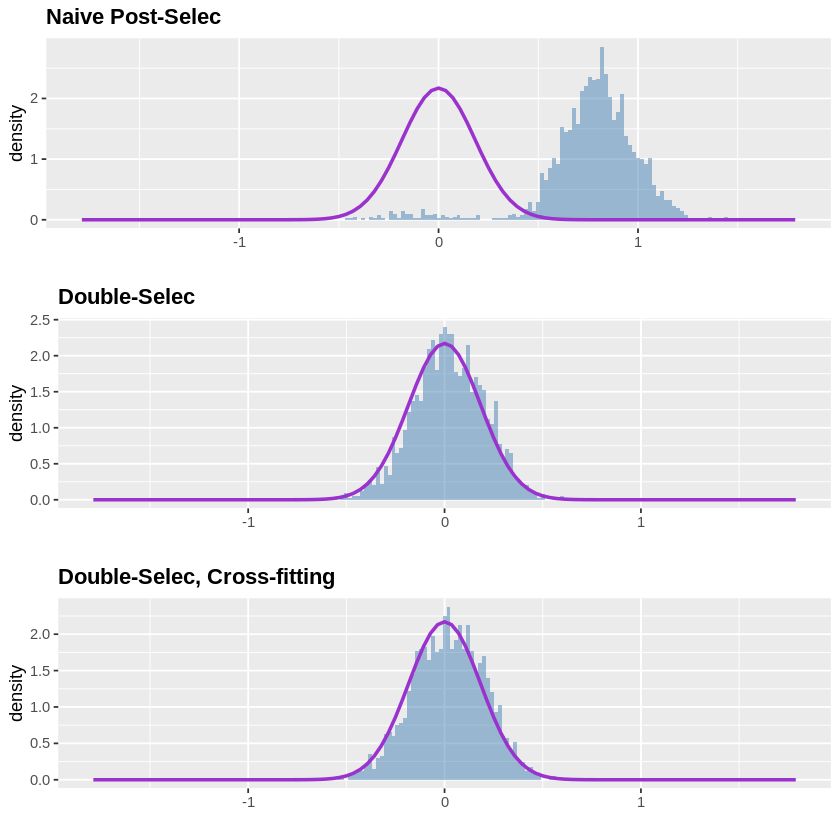

In [12]:
#######################
#######################
### 4. DRAW CHARTS ####
#######################
#######################

id = c(mapply(function(x) rep(x,R),1:3))
val = c(Results)-tau
data_res = data.frame(val = val, model = id)

M = max(abs(quantile(Results,.01,na.rm=T)),abs(quantile(Results,.99,na.rm=T)))
lb = -1.1*M; ub = 1.1*M

get.plot <- function(data,modelS,title="A Title",s){
  plot_res <- ggplot(subset(data, (model==modelS)), aes(x=val)) + 
    geom_histogram(binwidth = .02, alpha=.5, position='identity',fill="steelblue", aes(y = ..density..)) +
    scale_x_continuous(limits=c(lb,ub), name="") +
    ggtitle(title) + 
    stat_function(fun = dnorm, args=list(mean=0, sd=s), colour="darkorchid3", size=1) +
    theme(plot.title = element_text(lineheight=.8, face="bold"),legend.position="none")
  return(plot_res)
} # plot func

grid.arrange(get.plot(data_res,1,"Naive Post-Selec", mean(stdev)), get.plot(data_res,2,"Double-Selec", mean(stdev)), get.plot(data_res,3,"Double-Selec, Cross-fitting", mean(stdev)), ncol=1)


In [13]:
pdf("double-selec-simulations.pdf",width=14,height=4)
grid.arrange(get.plot(data_res,1,"Naive Post-Selection", mean(stdev)), 
             get.plot(data_res,2,"Double Selection",  mean(stdev)), 
             get.plot(data_res,3,"Double Selection, cross-fitted",  mean(stdev)), ncol=3)
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

png 
  2